<a href="https://colab.research.google.com/github/stelmanj/MusicAndLanguage/blob/master/Audio_Features_and_Lyric_Spread_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
install.packages("factoextra")

In [0]:
install.packages("ggridges")

In [0]:
library(tidyverse)
library(ggridges)

In [0]:
library(cluster)
library(factoextra)

In [0]:
library(parallel)

# Introduction

This is kind of a spin-off of the investigation done in "A Brief Analysis of Lyric Metrics." We take the same 100-song sample used in that study. The question we examine here is how do the songs from widely spoken languages vary in comparison to songs from non-widely spoken languages? 

In this chapter, I'll look at the spreads of a few audio and lyric features from 100 songs in 5 different languages (20 songs written in each language). I want to know if languages spoken across a wider geographical area produce a wider range of patterns in audio features and song lyrics. In other words, do the songs written by, say, Spanish-speaking artists vary more than songs written by, say, Indonesian-speaking artists? less? 

The following two languages make up the *widely spoken* group:

* English (en)

* Spanish (es)

The following three languages make up the *not widely spoken* group:

* Indonesian (id)

* Dutch (nl)

* Swahili (sw)

The distinction between the first and second groups is decided by whether a language is an official national language on at least three continents. 

I've used the Spotify Web API and the natural language processing package $\verb|quanteda|$ to calculate the following audio/ lyric features for audio and first few lines of lyrics in each of the 100 sampled songs. (20 songs were randomly sampled from each of the 5 languages.)

* Danceability (number between 0 and 1)

* Energy (number between 0 and 1)

* Key (category represented as a number between 0 and 11)*

* Loudness (number between -25 and 0)

* Speechiness (number between 0 and 1)

* Acousticness (number between 0 and 1)

* Valence (number between 0 and 1)**

* Tempo (number between 50 and 250)

* Type/Token Ratio, or TTR --> (# distinct words / # total words) in the first few lines of lyrics

*Each of the 12 numbers corresponds to one of the 12 keys on the chromatic scale, (e.g.  C, C\#, D, ..., A, A\#, B).

**I'm not entirely sure how Spotify measures valence, but I have the understanding that is an overall measure of how "happy" a song decidedly is based on other features.


Let's load in the data frames we made in DataPreparation.

In [0]:
esinw_df <- read.csv(
  "https://github.com/stelmanj/MusicAndLanguage/blob/master/AFS_esinw.csv?raw=true",
  row.names = 1, stringsAsFactors = FALSE) 

Let's make sure it looks right.

In [0]:
head(esinw_df)

,sid,danceability,energy,key,loudness,speechiness,acousticness,valence,tempo,lang,Types,Tokens,TTR
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>,<dbl>
1,1AvAl5fj5mhoLHVo0to1xr,0.697,0.298,0,-16.929,0.0319,0.0411,0.233,113.571,nl,64,90,0.7111111
2,5pz1Q9QFHWsUBZiJ73Jx3j,0.579,0.815,10,-7.603,0.0332,0.1000,0.556,155.577,nl,95,188,0.5053191
3,6eVj2ARRKQiy2Gb9Za7jnf,0.701,0.866,9,-4.632,0.0298,0.0535,0.933,119.949,nl,63,140,0.4500000
4,5uswrfRMA6MpRICWXEE1Uq,0.631,0.921,9,-3.248,0.0447,0.1380,0.370,108.055,nl,66,114,0.5789474
5,2ef2rQVgykMmHX47tjecDp,0.542,0.704,1,-7.953,0.0364,0.0215,0.253,119.942,nl,45,87,0.5172414
6,23lfdALTPtgNbJrzhRnfks,0.469,0.603,10,-8.358,0.0333,0.0893,0.231,131.739,nl,58,133,0.4360902


# EDA

### Density plots

The plots below show the density curves, with each color-coded by language. For every measure besides Key, the density curves show us something about center, shape, and spread of their distributions among the songs of each language. 

Because key is actually a categorical variable, and not a quantitative variable, I used a different type of density plot for Key. Each key on the chromatic scale is associated with a certain value, 0-11, featured on the x-axis. The darker the shading at a value of x, the more songs written in the key associated with that x-value turned up in the sample. The idea is not to look for similarities in the locations of dark and light shading, but rather to compare and contrast the distribution of pigmentation across whole strips. This helps us get a better look at spread, which is all we are interested in, as shape and center don't have the same kind of meaning when dealing with a categorical variable as with quantitative variables.


In [0]:
# we don't need cols 1, 11 & 12 (sid, Types & Tokens)
esinw_df2 <- lapply(c(2:9,13), function(x){  
  cbind(
    # each has three columns: the measure's value, the language, and the measure's name
    esinw_df[,c(x,10)], measure = names(esinw_df[x])) %>%
    # and rename the measure's value column as "value" so we can rbind all of the dfs later
    dplyr::rename(value = names(esinw_df[x]))
})

# now rbind them
esinw_df3 = esinw_df2[[1]]
for (i in c(2:9)){
  esinw_df3 <- rbind(esinw_df3,esinw_df2[[i]])
}

# and take out the trash
rm(esinw_df2)


Picking joint bandwidth of 0.0675

Picking joint bandwidth of 0.0852

Picking joint bandwidth of NaN

Warning message in min(data$x, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
Warning message in max(data$x, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Picking joint bandwidth of 1.34

Picking joint bandwidth of 0.017

Picking joint bandwidth of 0.128

Picking joint bandwidth of 0.115

Picking joint bandwidth of 12.2

Picking joint bandwidth of 0.042

Warning message in FUN(X[[i]], ...):
“no non-missing arguments to max; returning -Inf”


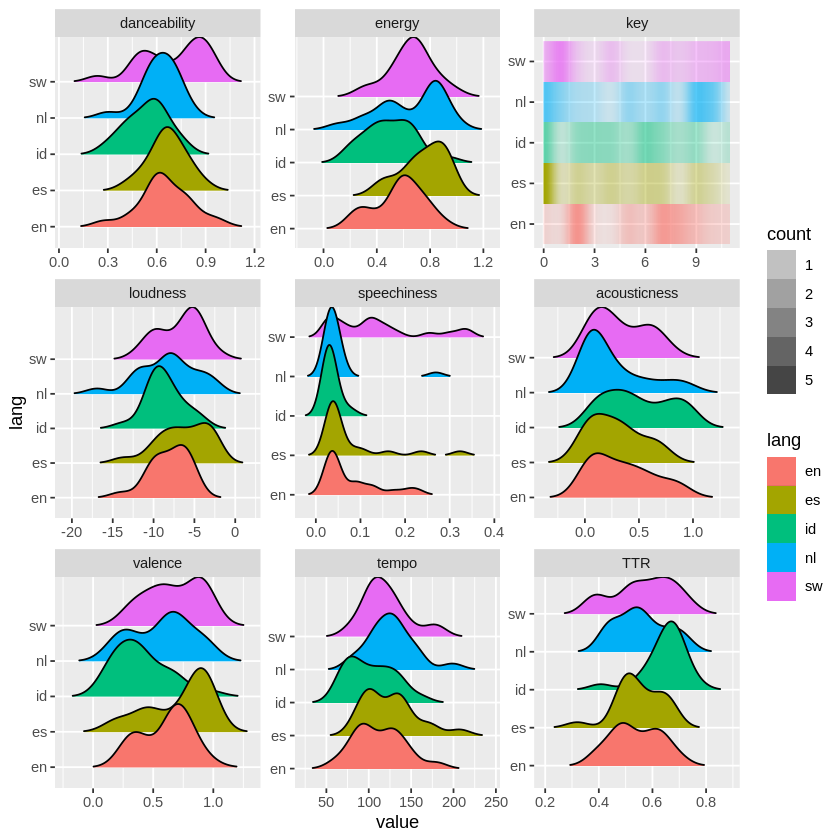

In [0]:
# GG Ridge Plot

# make a ggplot and facet it by language
f1 <- ggplot(esinw_df3, aes(x = value, y = lang, fill = lang)) + 
  facet_wrap(measure~. , ncol = 3, scales = 'free')
# add some density plots to it to it for teh numical metric
f2 <- f1 + geom_density_ridges_gradient(data = subset(esinw_df3,measure!='key'),
                               scale = 1.8, rel_min_height = 0.01)
# add some gradient for the key (categorical) metric
f3 <- f2 +   stat_density(data = subset(esinw_df3,measure=='key'), 
                          aes(alpha = stat(count)),
               geom = "raster", position = "identity", bw = 1/2)
f3

In the Key plot (top right), the pink strip seems to be the splotchiest-looking. This means that there appears to be less variation of song key among songs written in English than among songs written in other languages. 

It would seem that the distributions of many features of English (pink) and Spanish (olive) music have similar shapes (danceability, loudness, speechiness, acousticness, tempo, and TTR). For all of these but loudness, these distributions seem to have commonalities not just of shape, but also of center and spread (ignoring abnormal tail behavior). 

Swahili's distribution (purple) always tends to march to the beat of its own drum (terrible pun intended). Truthfully though, if you look at all nine of the plots, there doesn't seem to be one in which the purple curve (or strip) seems to mimic the distribution of another color. 

What's interesting about Indonesian music (teal) is that acousticness is basically its only bimodally distributed feature. All its other features are distributed pretty unimodally, which is unusual. Meanwhile, every other language's music has at least two features that are distributed bimodally. 

All in all, there doesn't seem to be a super clear unifying difference between the more widely-spoken and less widely-spoken languages.

### Box plots

The boxplots below show the five-number-summaries and outliers for all of the same data that was used in the density curves above. Key, the categorical feature, is portrayed in a violin plot instead of a boxplot so that it is easier to see the concentrations at individual values of key.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



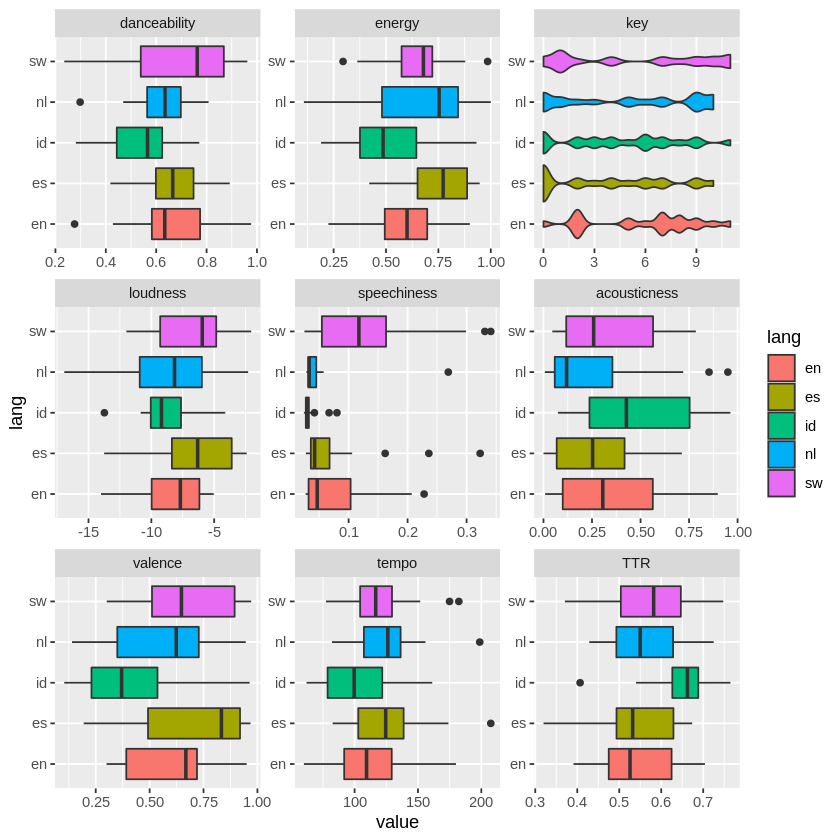

In [0]:
# boxplots
# make the setup
f1 <- ggplot(esinw_df3, aes(y = value, x = lang, fill = lang))+ 
  facet_wrap(measure~. , ncol = 3, scales = 'free')
# boxplots for the true numeric variables
f2 <- f1+geom_boxplot(data = subset(esinw_df3, measure!='key')) + 
  coord_flip()
# violin plot for key (the categorical variable in disguise)
f3 <- f2+geom_violin(adjust = 1/5, data = subset(esinw_df3,measure=='key')) +
  coord_flip()
f3

There are lots of outliers in speechiness, which, while prominent in the density curves, is even more prominent here, especially for Indonesian. 

There don't seem to be any consistent patterns. As far as what these plots portray, there is no clear relationship between song feature distribution characteristics and widespokenness. 

# Methods

We want to know whether or not there is a difference between extent of variation within the music of more widely spoken languages vs music of less widely spoken languages. We're going to approach exploring this in two ways. 

* Running a statistical hypothesis test

* Performing K-means clustering

### Rank Sum tests

Rank Sum tests are usually not used in the way I am using them here. The Wilcoxon Rank Sum test is designed to be run on a data set whose observations are all in the same units. In order to deal with this restriction, I have to take some intermediate steps. 

I'll first calculate the spread metric (standard deviation or IQR) for each of the nine features for each of the 5 languages (5 * 9 = 45 calculations). Second, within each of the nine features separately, I'll perform ranking on the spread metric. Third, I'll pool together those *ranks* (each will be a value 1-5) to form the set of "observations" on which the Wilcoxon Rank Sum Test will be performed. I'll be giving each one of the 45 "observations" a label specifying which of the two contributing "populations" (widely spoken/ not widely spoken) it pertains to. During the Rank Sum test, each one will get a new overall rank based on where it falls relative to the rest of the "observations". 

Those "observations" originating from data of English or Spanish music pertain to the **widely spoken** "population", and those "observations" originating from data of Indonesian, Dutch, or Swahili music pertain to the **not widely spoken** "population."

### Kmeans Clustering

Unlike the Wilcoxon Rank Sum test, Kmeans, a clustering method, is built to handle feature-rich data. However, it is not built for computing how much evidence exists in favor of the clustering formation hypothesized. It only determines which of all the possible clustering formations has the most evidence in favor of it. Therefore I will take some additional steps to interpret the results of Kmeans as I would the outcome of a statistical test.

# Results

### Rank Sum tests

We'll perform two Wilcoxon Rank Sum tests. To start, we will use standard deviation as a metric of spread. Following that, we will repeat the same process but with IQR as our spread metric.

In [0]:
# before anything else, we'll have to take some special measures to treat the key variable as categorical instead of numeric.

# turn the 0-11 key variable into 12 bernoulli variables with 20 observations each
dummies <- esinw_df[order(esinw_df$lang),] %>% select(key) 

# and its levels should be saved as separate lists
dum.levels <- levels(factor(unlist(dummies)))
key <- lapply(dummies, 
              function(x) table(sequence(nrow(dummies)), factor(x, levels = dum.levels)))$key

In [0]:
# Now, instead of this
head(dummies)

,key
,<int>
22,11
42,10
45,8
56,7
57,2
58,9


In [0]:
# we have this 
head(key)

   
    0 1 2 3 4 5 6 7 8 9 10 11
  1 0 0 0 0 0 0 0 0 0 0  0  1
  2 0 0 0 0 0 0 0 0 0 0  1  0
  3 0 0 0 0 0 0 0 0 1 0  0  0
  4 0 0 0 0 0 0 0 1 0 0  0  0
  5 0 0 1 0 0 0 0 0 0 0  0  0
  6 0 0 0 0 0 0 0 0 0 1  0  0

#### Standard Deviation Rank Sum test

The first of the following tables contains the standard deviation of each feature for each individual language. The second table replaces the standard deviations with their ranks. 

Step 1: Calculate the standard deviation for each of the nine features for each of the five individual languages.


In [0]:
# Rank sum test of standard deviations
# 1. make the matrix of "data"

# add a column for widespokenness to the "data" matrix of standard deviations
sds <- esinw_df %>% select(-sid, -Tokens, -Types) %>%
  group_by(lang) %>% summarise_all(sd) %>% ungroup() %>%
  mutate(is_widely_spoken = ifelse(lang %in% c('en','es'), T, F))

# use a different method for key, as it's a not actually a numeric variable.
# for each language, we made a binary vector for each of the 12 possible values, 
## with 1s in all places where key = key[i], and 0s elsewhere.
## Take the sd of each of those 5 vectors, and then take the mean of those 5 sds
key_sds <- sapply(0:4,function(c){
  stdevskeys = c()
  for (i in 1:12){
    stdevskeys = append(stdevskeys,
                        sd(key[(c*(20) + (1:20)),i]))}
  mean(stdevskeys)}) 

# store that in the key column of the standard devation data frame
sds$key <- key_sds

# show the standard deviations
sds %>% 
  mutate(`widely spoken?` = ifelse(is_widely_spoken, "yes", "no")) %>%
  select(-is_widely_spoken)

lang,danceability,energy,key,loudness,speechiness,acousticness,valence,tempo,TTR,widely spoken?
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
en,0.1607261,0.1869324,0.2275846,2.302330,0.06248847,0.2843769,0.1994177,29.55932,0.09128328,yes
es,0.1144002,0.1642343,0.2249290,3.106435,0.07818603,0.2361951,0.2600962,31.87556,0.08620658,yes
id,0.1279928,0.1893246,0.2488772,2.234725,0.01420918,0.3069545,0.2251435,27.92545,0.07668810,no
nl,0.1131354,0.2469996,0.2317776,3.621842,0.05255047,0.2937826,0.2515147,27.10288,0.09430071,no
sw,0.2002997,0.1653345,0.2330659,2.684877,0.10075234,0.2423239,0.2232064,26.67659,0.11343660,no


Step 2: Rank the five languages, within each feature separately, by standard deviation. 

In [0]:
# take their ranks
sd_ranks = sds
for (i in c(2:10)){
  sd_ranks[,i] <- sapply(sds[,i],identity) %>% rank
}

# show the ranks
sd_ranks %>%
  mutate(`widely spoken?` = ifelse(is_widely_spoken, "yes", "no")) %>%
  select(-is_widely_spoken)

lang,danceability,energy,key,loudness,speechiness,acousticness,valence,tempo,TTR,widely spoken?
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
en,4,3,2,2,3,3,1,4,3,yes
es,2,1,1,4,4,1,5,5,2,yes
id,3,4,5,1,1,5,3,3,1,no
nl,1,5,3,5,2,4,4,2,4,no
sw,5,2,4,3,5,2,2,1,5,no


In [0]:
#Let's run a statistical test to evaluate the variances associated with each langauge. 

# we need to make a dataframe that has two colums, a value column and a label column
# the value column will actualy be a rank column (remember, we are takeing ranks of ranks)
# the label column will contain 40 TRUEs (indicating songs written in widely spoken languages)
## and 60 FALSEs (indicating songs written in not widely spoken languages)
wilcox_df <-  sd_ranks[sd_ranks$is_widely_spoken,1:10] %>% stack() %>% .[,1] %>%
  cbind("widely_spoken") %>% 
  rbind(
    sd_ranks[!sd_ranks$is_widely_spoken,1:10] %>% stack() %>% .[,1] %>%
      cbind("not_widely_spoken")
  ) %>% data.frame() 
names(wilcox_df) <- c("rank_sd","cat")
wilcox_df <- wilcox_df %>% mutate(rank_sd = as.character(rank_sd)) %>%
  mutate(rank_sd  = as.numeric(rank_sd))

Warning message:
“NAs introduced by coercion”


Step 3: Take the values from Table 2 to be the set of "observations" on which the Wilcoxon Rank Sum Test is to be performed. Determine each one's individual *overall* rank. Keep track of which "observations" belong to which "population."

In [0]:
# create a new table to show my work
wilcox_table = wilcox_df

# change the categorical values to make the table more readable and smaller
wilcox_table$widely <- wilcox_table$cat %>% sapply(
  function(x) ifelse(x == "widely_spoken","`yes`",""))
# do this separately for the two language types
wilcox_table$` spoken?` <- wilcox_table$cat %>% sapply(
  function(x) ifelse(x == "not_widely_spoken","`no`",""))

# get rid of the old categorical variable column
wilcox_table$cat = NULL

# get the ranks like the wilcox test does, and save in obs.rank
obs.rank = wilcox_df$rank_sd %>% rank
# make these more readable by getting rid of ".0"s and put in "``"s for separation
wilcox_table$obs_rank = obs.rank %>% as.character() %>%
  sapply(function(x) paste0("`",x,"`"))

# make the values more readable by getting rid of ".0"s
wilcox_table$obs_value = wilcox_df$rank_sd 

# put it all together
wilcox_table <- wilcox_table %>% 
  select(obs_value, obs_rank, widely, ` spoken?`) %>%
  mutate(obs_value = as.character(obs_value))

# show the first third of the table
wilcox_table[order(wilcox_table$obs_rank)[1:15],] %>%
  t() %>% data.frame()

,X4,X7,X9,X20,X29,X37,X41,X44,X46,X5,X11,X13,X19,X24,X31
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
obs_value,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3
obs_rank,`14`,`14`,`14`,`14`,`14`,`14`,`14`,`14`,`14`,`23`,`23`,`23`,`23`,`23`,`23`
widely,`yes`,`yes`,`yes`,`yes`,,,,,,`yes`,`yes`,`yes`,`yes`,,
spoken?,,,,,`no`,`no`,`no`,`no`,`no`,,,,,`no`,`no`


In [0]:
# show the second third of the table
wilcox_table[order(wilcox_table$obs_rank)[16:30],] %>%
  t() %>% data.frame()



,X35,X42,X45,X3,X10,X12,X17,X27,X32,X40,X43,X49,X16,X18,X26
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
obs_value,3,3,3,4,4,4,4,4,4,4,4,4,5,5,5
obs_rank,`23`,`23`,`23`,`32`,`32`,`32`,`32`,`32`,`32`,`32`,`32`,`32`,`41`,`41`,`41`
widely,,,,`yes`,`yes`,`yes`,`yes`,,,,,,`yes`,`yes`,
spoken?,`no`,`no`,`no`,,,,,`no`,`no`,`no`,`no`,`no`,,,`no`


In [0]:
# show the last third of the table
wilcox_table[order(wilcox_table$obs_rank)[31:45],] %>%
  t() %>% data.frame()

In [0]:
# delete the table, we don't need it anymore
rm(wilcox_table)

Above are the values used as observations, their overall ranks, and whether or not they each belong to the widely spoken language group. They're ordered by overall rank. 

Now let's run the test to see if the variation behavior of songs' audio/ lyric features (as can be detected at the standard deviation level) is associated with how widely spoken the language of their lyrics:

Alternative Hypothesis: The features of music written in more widely spoken languages will vary to either a greater or a lesser extent than the features of music written in less widely spoken languages.

In [0]:
# now the test
wilcox.test(rank_sd ~ cat, data = wilcox_df, alternative = "two.sided")

Warning message in wilcox.test.default(x = c(3, 1, 5, 4, 5, 2, 5, 3, 4, 1, 5, 3, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  rank_sd by cat
W = 279, p-value = 0.4013
alternative hypothesis: true location shift is not equal to 0


As 0.401 is a very large p-value, it seems there is not evidence of a unidirectional relationship between varied-ness within audio/ lyric features and how widely spoken a language is. Or at least there is not evidence of such a relationship that is detectable on the standard deviation level. 

#### IQR Rank Sum test

The first of the following tables contains the IQR of each feature for each individual language. The second table replaces the IQRs with their ranks. 

In [0]:
# Rank sum test of iqrs
iqrs <- esinw_df %>% select(-sid, -Tokens, -Types) %>%
  group_by(lang) %>% summarise_all(IQR) %>% ungroup() %>%
  mutate(is_widely_spoken = ifelse(lang %in% c('en','es'), T, F))

# use a different method for key, (same drill as for sds)
key_iqrs <- sapply(0:4,function(c){
  iqrkeys = c()
  for (i in 1:12){
    iqrkeys = append(iqrkeys,
                        IQR(key[(c*(20) + (1:20)),i]))
  }
  mean(iqrkeys)
  }) 

iqrs$key <- key_iqrs

Step 1: Calculate the IQR for each of the nine features for each of the five individual languages.

In [0]:
# show the standard deviations
iqrs %>%
  mutate(`widely spoken?` = ifelse(is_widely_spoken, "yes", "no")) %>%
  select(-is_widely_spoken)

lang,danceability,energy,key,loudness,speechiness,acousticness,valence,tempo,TTR,widely spoken?
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
en,0.19150,0.20275,0.02083333,3.80000,0.071275,0.464075,0.32800,37.51150,0.14966286,yes
es,0.14950,0.23650,0.08333333,4.76075,0.031775,0.349625,0.42675,35.80675,0.13557898,yes
id,0.18025,0.26900,0.00000000,2.40550,0.005200,0.516000,0.30625,43.10125,0.06176096,no
nl,0.13375,0.36300,0.00000000,4.94500,0.013475,0.296925,0.37800,28.96450,0.13508692,no
sw,0.32975,0.14675,0.02083333,4.46025,0.108750,0.447300,0.38325,25.14725,0.14297928,no


Step 2: Rank the five languages, within each feature separately, by IQR. 

In [0]:
iqr_ranks = iqrs
for (i in c(2:10)){
  iqr_ranks[,i] <- sapply(iqrs[,i],identity) %>% rank
}

# show the ranks
iqr_ranks %>%
  mutate(`widely spoken?` = ifelse(is_widely_spoken, "yes", "no")) %>%
  select(-is_widely_spoken)

lang,danceability,energy,key,loudness,speechiness,acousticness,valence,tempo,TTR,widely spoken?
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
en,4,2,3.5,2,4,4,2,4,5,yes
es,2,3,5.0,4,3,2,5,3,3,yes
id,3,4,1.5,1,1,5,1,5,1,no
nl,1,5,1.5,5,2,1,3,2,2,no
sw,5,1,3.5,3,5,3,4,1,4,no


Now let's run a Wilcoxon Rank Sum test on the Inter-quartile ranges:

In [0]:
# we need to make a dataframe that has two colums, a value column and a label column
# the value column will actualy be a rank column (remember, we are taking ranks of ranks)
# the label column will contain 40 TRUEs (indicating songs written in widely spoken languages)
## and 60 FALSEs (indicating songs written in not widely spoken languages)
wilcox_df2 <-  iqr_ranks[iqr_ranks$is_widely_spoken,1:10] %>% 
  stack() %>% .[,1] %>%
  cbind("widely_spoken") %>% 
  rbind(
    iqr_ranks[!iqr_ranks$is_widely_spoken,1:10] %>% stack() %>% .[,1] %>%
      cbind("not_widely_spoken")
  ) %>% data.frame() 
names(wilcox_df2) <- c("rank_iqr","cat")
wilcox_df2 <- wilcox_df2 %>% mutate(rank_iqr = as.character(rank_iqr)) %>%
  mutate(rank_iqr = as.numeric(rank_iqr))

Warning message:
“NAs introduced by coercion”


Step 3: Take the values from Table 2 to be the set of "observations" on which the Wilcoxon Rank Sum Test is to be performed. Determine each one's individual *overall* rank. Keep track of which "observations" belong to which "population."

In [0]:
# create a new table to show my work
wilcox_table = wilcox_df2

# change the categorical values to make the table more readable and smaller
wilcox_table$widely <- wilcox_table$cat %>% sapply(
  function(x) ifelse(x == "widely_spoken","`yes`",""))
# do this separately for the two language types
wilcox_table$` spoken?` <- wilcox_table$cat %>% sapply(
  function(x) ifelse(x == "not_widely_spoken","`no`",""))

# get rid of the old categorical variable column
wilcox_table$cat = NULL

# get the ranks like the wilcox test does, and save in obs.rank
obs.rank = wilcox_df2$rank_iqr %>% rank
# make these more readable by getting rid of ".0"s and put in "``"s for separation
wilcox_table$obs_rank = obs.rank %>% as.character() %>%
  sapply(function(x) paste0("`",x,"`"))

# make the values more readable by getting rid of ".0"s
wilcox_table$obs_value = wilcox_df2$rank_iqr 

# put it all together
wilcox_table <- wilcox_table %>% 
  select(obs_value, obs_rank, widely, ` spoken?`) %>%
  mutate(obs_value = as.character(obs_value))

# show the first third of the table
wilcox_table[order(obs.rank)[1:15],] %>%
  t() %>% data.frame()

,X25,X29,X33,X36,X40,X42,X47,X48,X30,X31,X4,X5,X9,X14,X15
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
obs_value,1,1,1,1,1,1,1,1,1.5,1.5,2,2,2,2,2
obs_rank,`4.5`,`4.5`,`4.5`,`4.5`,`4.5`,`4.5`,`4.5`,`4.5`,`9.5`,`9.5`,`14.5`,`14.5`,`14.5`,`14.5`,`14.5`
widely,,,,,,,,,,,`yes`,`yes`,`yes`,`yes`,`yes`
spoken?,`no`,`no`,`no`,`no`,`no`,`no`,`no`,`no`,`no`,`no`,,,,,


In [0]:
#show the second third of the table
wilcox_table[order(obs.rank)[16:30],] %>%
  t() %>% data.frame() 

,X37,X46,X49,X6,X12,X18,X20,X24,X35,X41,X43,X7,X32,X3,X10
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
obs_value,2,2,2,3,3,3,3,3,3,3,3,3.5,3.5,4,4
obs_rank,`14.5`,`14.5`,`14.5`,`22.5`,`22.5`,`22.5`,`22.5`,`22.5`,`22.5`,`22.5`,`22.5`,`27.5`,`27.5`,`32.5`,`32.5`
widely,,,,`yes`,`yes`,`yes`,`yes`,,,,,`yes`,,`yes`,`yes`
spoken?,`no`,`no`,`no`,,,,,`no`,`no`,`no`,`no`,,`no`,,


In [0]:
#show the last third of the table
wilcox_table[order(obs.rank)[31:45],] %>%
  t() %>% data.frame() 

,X11,X13,X17,X27,X44,X50,X8,X16,X19,X26,X28,X34,X38,X39,X45
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
obs_value,4,4,4,4,4,4,5,5,5,5,5,5,5,5,5
obs_rank,`32.5`,`32.5`,`32.5`,`32.5`,`32.5`,`32.5`,`41`,`41`,`41`,`41`,`41`,`41`,`41`,`41`,`41`
widely,`yes`,`yes`,`yes`,,,,`yes`,`yes`,`yes`,,,,,,
spoken?,,,,`no`,`no`,`no`,,,,`no`,`no`,`no`,`no`,`no`,`no`


In [0]:
# delete the table, we don't need this anymore
rm(wilcox_table)

Now let's run the test to see if the variation behavior of songs' audio/ lyric features (as can be detected at the IQR level) is associated with how widely spoken the language of their lyrics:

Alternative Hypothesis: The features of music written in more widely spoken languages will vary to either a greater or a lesser extent than the features of music written in less widely spoken languages.

In [0]:
# now the test
wilcox.test(rank_iqr ~ cat, data = wilcox_df2, alternative = "two.sided")

Warning message in wilcox.test.default(x = c(3, 1, 5, 4, 5, 1, 1.5, 1.5, 3.5, 1, :
“cannot compute exact p-value with ties”



	Wilcoxon rank sum test with continuity correction

data:  rank_iqr by cat
W = 181.5, p-value = 0.1513
alternative hypothesis: true location shift is not equal to 0


It's a smaller p-value than we got from standard deviation. Still, 0.1513 is too large of a p-value to provide evidence supporting the existence of a one-way spectrum of variablity in audio/ lyric features associated with how widely spoken a language is. 

Based on these results, there is *no relationship* between varied-ness in audio/ lyric features and wide-spokenness of lyric language. 

### Kmeans Clustering

In [0]:
# prep sd df for kmeans
sds <- sds %>% as.data.frame()
rownames(sds) <- sds$lang
sds <- sds %>% select(-lang, -is_widely_spoken)

# prep iqr df for kmeans
iqrs <- iqrs %>% as.data.frame()
rownames(iqrs) <- iqrs$lang
iqrs <- iqrs %>% select(-lang, -is_widely_spoken)

I used the $\verb|cluster|$ and $\verb|factoextra|$ packages to conduct Kmeans clustering analysis, first by Standard Deviation, and then by IQR. 

#### Kmeans Clustering by Standard Deviations

K-means clustering with 2 clusters of sizes 2, 3

Cluster means:
  danceability    energy       key loudness speechiness acousticness   valence
1    0.1375631 0.1755834 0.2262568 2.704382  0.07033725    0.2602860 0.2297569
2    0.1471426 0.2005529 0.2379069 2.847148  0.05583733    0.2810203 0.2332882
     tempo        TTR
1 30.71744 0.08874493
2 27.23497 0.09480847

Clustering vector:
en es id nl sw 
 1  1  2  2  2 

Within cluster sum of squares by cluster:
[1] 3.010241 1.822857
 (between_SS / total_SS =  75.1 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

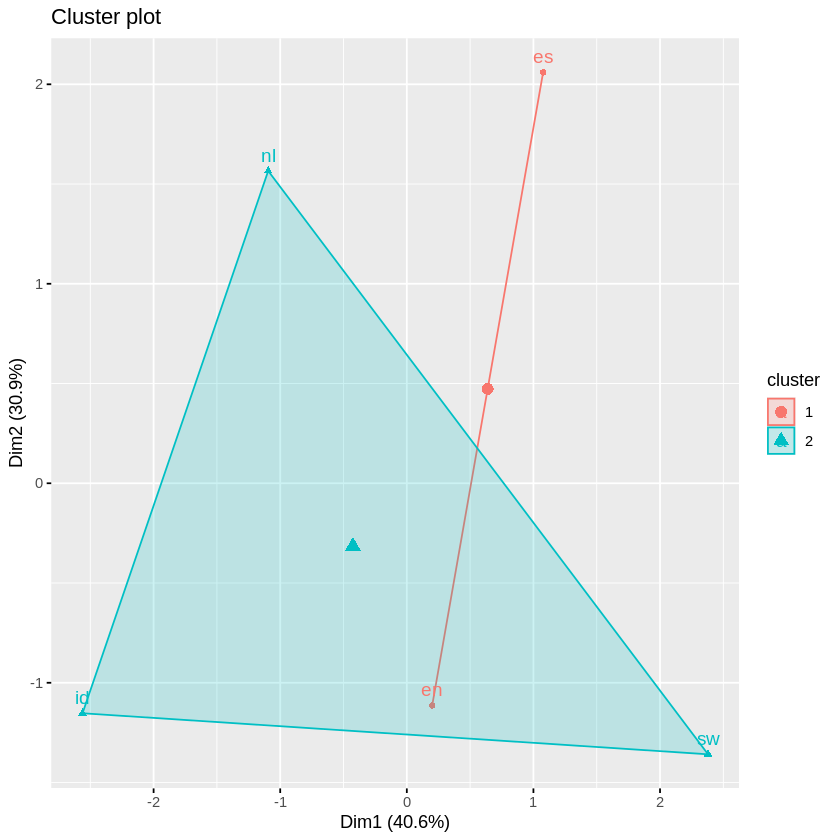

In [0]:
# We want to see the data split into 2 clusters.
# So we specify "centers" to be 2.
km_sds <- kmeans(sds, centers = 2, nstart = 25)

# lets take a look at the important information about our clusters.
km_sds

# And plot the result wit with fviz_cluster
fviz_cluster(km_sds, data = sds)

Take a look at the numbers in the table below, which is a reformated version of the table shown in the R output chunk above. The row containing cluster means for the cluster which was formed around English and Spanish is labeled "widely spoken." Seven times out of nine, the features of music from widely spoken languages varied *less*, on average, than features of music from "not widely spoken" languages, judged on the basis of standard deviation. 

In [0]:
# make a table for the infomation that matters with useful labels
table5 <- km_sds$centers %>% round(3) %>% data.frame()

# correct rownames
rownames(table5) <- c("widely spoken","not widely spoken")

# show table
table5

,danceability,energy,key,loudness,speechiness,acousticness,valence,tempo,TTR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
widely spoken,0.138,0.176,0.226,2.704,0.070,0.260,0.230,30.717,0.089
not widely spoken,0.147,0.201,0.238,2.847,0.056,0.281,0.233,27.235,0.095


#### Kmeans Clustering by IQRs

Let's try it again with IQR instead of standard deviation.

K-means clustering with 2 clusters of sizes 2, 3

Cluster means:
  danceability    energy        key loudness speechiness acousticness   valence
1      0.23175 0.2548750 0.01041667 4.702625  0.06111250    0.3721125 0.3806250
2      0.17375 0.2360833 0.03472222 3.655417  0.03608333    0.4432333 0.3536667
     tempo       TTR
1 27.05588 0.1390331
2 38.80650 0.1156676

Clustering vector:
en es id nl sw 
 2  2  2  1  1 

Within cluster sum of squares by cluster:
[1]  7.461887 31.961671
 (between_SS / total_SS =  80.9 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

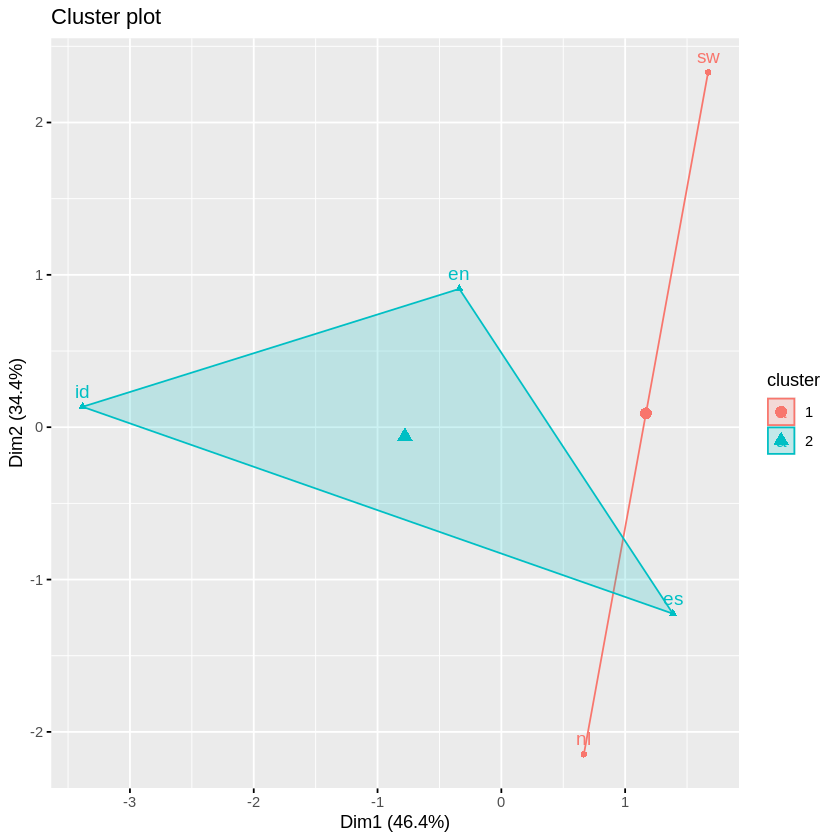

In [0]:
# once again, we'll start with 2 clusters
km_iqrs <- kmeans(iqrs, centers = 2, nstart = 25)
# information, please
km_iqrs
# Plotting the result...
fviz_cluster(km_iqrs, data = iqrs)

The algorithm did not split the data into the clusters we were hoping to see. Therefore, there is not evidence worth looking further into of relationship between varied-ness in audio/ lyric features and how widely spoken a language is at the IQR level.


#### So what?

The clusters actually split the languages into widely and not widely spoken languages! 

But what does that mean? We'll need to do more investigating to see if anything can actually be concluded. 

There are ${5 \choose 0} + {5 \choose 1} + {5 \choose 2} = 1 + 5 + 10 = 16$ possible ways that Kmeans could split 5 languages into exactly two groups, $5 + 10 = 15$ ways if we force each group to have at least one member. 

If we assume that, under a null hypothesis of *$H_0$: no relationship between varied-ness in audio/ lyric features and how widely spoken a language is*, there is an equal chance of each clustering outcome, there would be a $\frac{1}{16}$ or $\frac{1}{15}$ chance that, we would observe the outcome we got (we'll call this the target outcome). 

But we can do better than that. Rather than assuming equal chance and using fractions to determine the probability of seeing the outcome we observed (the target outcome), let's use simulations to come up with a more insightful estimate for our p-value. 

In [0]:
# let's get rid of any extra baggage before we get too deep 
esinw_df2 <- dplyr::select(esinw_df,-sid,-Tokens,-Types)

In [0]:
# checks to see if the simulated data's 2-means clustering outcome was the same as the target
# Inputs: df <data.frame> (a dataframe with the same structure as esinw_df2)
  # spread_fxn <function> (a function for computing spread, for example sd() or iqr())
  # target <chr vector> (the language labels making up the one cluster of the target outcome)
# Output: <logical> (True if the simulated data's 2-means clustering outcome was the same as the target, FALSE otherwise)
check_clusters <- function(df, spread_fxn, target){
  dummies <- df[order(df$lang),] %>% select(key) 
  # and its levels
  dum.levels <- levels(factor(unlist(dummies)))
  key <- lapply(dummies, function(x) {
    table(sequence(nrow(dummies)), factor(x, levels = dum.levels))
  })$key
  # now the spread metric
  spreads <- df %>% group_by(lang) %>% summarise_all(spread_fxn) %>% ungroup() 
  # use a different method for key, as it's a not actually a numeric variable.
  # for each language, make a binary vector for each of the 12 possible values, 
  ## with 1s in all places where key = key[i], and 0s elsewhere
  ## run spread_fxn on each of those 5 vectors individually, 
  ## and then take the mean of those 5 values
  key_spreads <- sapply(0:4,function(c){
    spreadskeys = c()
    for (i in 1:12){
      spreadskeys = append(spreadskeys,
                          spread_fxn(key[(c*(20) + (1:20)),i]))}
    mean(spreadskeys)}) 
  # store that in the key column of the standard devation data frame
  spreads$key <- key_spreads
  # prep spread df for kmeans
  spreads <- spreads %>% as.data.frame()
  rownames(spreads) <- spreads$lang
  spreads <- spreads %>% select(-lang)
  # We want to see the data split into 2 clusters.
  # So we specify "centers" to be 2.
  km_spreads <- kmeans(spreads, centers = 2, nstart = 25)
  # check if the clusters we got are the ones we wanted.
  identical(target,
            names(which(km_spreads$cluster==km_spreads$cluster[target[1]])))
}

This will go very slowly, so we'll speed it up with help from R's $\verb|parallel|$ package

In [0]:
# function to simulate the data n times and give the proportion of simulations whose 2-means clustering outcome matched the target
# Inputs: n <integer> (the number of simulations)
  # df <data.frame> (a dataframe with the same structure as esinw_df2)
  # col2sim <chr> (the name of the label column)
  # spread_fxn <function> (a function for computing spread, for example sd() or iqr())
  # target <chr vector> (the language labels making up the one cluster of the target outcome)
# Output: <logical> (True if the simulated data's 2-means clustering outcome was the same as the target, FALSE otherwise)
ptarget_outcome <- function(n, df, col2sim, spread_fxn, target){
  # this is for parallel computing, these clusters have nothing to do with the k-means clusters
  cl <- makeCluster(detectCores())
  # same with these clusters: 
  # now we need to tell the master node what variables to load up each worker node with so they can each do their job
  clusterExport(cl, envir = environment(),
                varlist = c("n", "df", "col2sim", "spread_fxn", "target", "check_clusters", "kmeans",
                            "%>%", "select", "group_by", "ungroup", "summarise_all"))
  p <- mean(parSapply(
      cl = cl, X = 1:n, FUN = function(x) {
        # randomly scramble the label column (in order to randomly assign 20% of the songs to each language)
        df[,col2sim] <- sample(df[,col2sim])
        # see if the simulated data's 2-means clustering outcome was the same as the target
        check_clusters(df = df, spread_fxn = spread_fxn, target = target)
  })) # count the number of TRUEs and divide it by n
  stopCluster(cl)
  return(p)
}

Now the moment of truth...

In [0]:
set.seed(74)
prob_sds_n100000p <- ptarget_outcome(
  n = 100000, df = esinw_df2, col2sim = "lang", spread_fxn = sd, target = c("en","es"))
print(prob_sds_n100000p)

[1] 0.06432


Roughly speaking, when there is no relationship between varied-ness in audio/ lyric features and how widely spoken a language is, the target outcome has about a 0.06432 chance of occurring.

We saw that in the standard deviation case, the target outcome,

* English (en), Spanish (es)

* Indonesian (id), Dutch (nl), Swahili (sw),

actually did what we were hoping, and split the real languages into widely and not widely spoken languages.

But what does that mean? We've needed to do more investigating to see if anything can actually be concluded. 

#### **Statistical Hypothesis test:** 

$H_0$: There is *no relationship* between varied-ness in audio/ lyric features and how widely spoken a language is.

$H_a$: There is a *relationship* between varied-ness in audio/ lyric features and how widely spoken a language is.

* $\alpha = .05$

* $p.value = 0.06432$

We discovered that, under the null hypothesis of no relationship, 0.06432 is the probability that the clustering procedure groups the languages in the following way:

* English (en), Spanish (es)

* Indonesian (id), Dutch (nl), Swahili (sw)

Our p-value of 0.06432 is not small enough. We fail to reject the null hypothesis of no relationship between varied-ness in audio/ lyric features and how widely spoken a language is, on the grounds of standard deviation.

# Discussion

Standard deviation is not outlier-resistant, which is one way IQR differs from it. Standard Deviation is also more inflated by bimodal distribution behavior than IQR is, and as we saw in those density curves, there were quite a few cases of bimodality. I found it interesting that the outcome in the standard deviation version of the Kmeans test was closer to rejecting the null than the outcome in the IQR version. Yet, in the Rank Sum tests, though in neither version of the test was the null rejected, the standard deviation version resulted in a p-value that was, by far, the least rejectable (0.531).

I have a theory for why this would be. Because ranks were used instead of the original values in the Rank Sum tests, magnitude of difference was not able to have any influence. However, magnitude of difference *was* able to influence the Kmeans test. This difference between Rank Sum test and Kmeans test didn't seem to change much in the case of IQR. However, it made a huge difference in the case of standard deviation. Standard deviation has more moving parts than IQR, making it more likely that distances between two values in the set of 45 standard deviations would vary more than distances between two values in the set of 45 IQRs. This might be one reason why the conclusions of the two hypothesis tests for standard deviation differed. 

Let's talk about what we observed in the standard-deviation based kmeans [table](https://colab.research.google.com/drive/1TUQto0h05axO4ak-X6CxlFMBNYuMqpWf#scrollTo=O0ZlwDsv1fMp&line=7&uniqifier=1). It was made apparent, for 78% of features, that there was less in-language variation in music from widely spoken languages than music from less widely spoken languages. 

This, I found quite interesting and unexpected. Initially, I predicited that, if anything, there would be *more* variation among songs from *more* widely spoken languages. The *more* places a language is spoken, the *more* speakers it has. The *more* speakers a language has, the *more* singers it has. The *more* singers that contribute their voices to music in a language, the *more* variation exists among music produced in it. 

However, there is another side to all of this. Even if the *list* of songs I began with for this study were truly a *simple random sample* of *all* the songs from each language, I'm still limited to only the songs with:

* audio feature data on Spotify,

* lyrics on Musixmatch,

* lyrics encoded in a way that the software I'm using can process,

* encoded lyrics decoded in a way that is recognized (as non-gibberish) by the language-detection function,

* and decoded lyrics' languages correctly detected by the language-detection function.

Probably, the more commercially successful the song, the more likely it is to have remained in the sampleable dataset by the end of all this. Therefore, we can't think just about the music that gets *made* by a lot of people. We have to think also about the music that gets *heard* by a lot of people. There are certain qualities associated with songs that get popular. One of them, undoubtedly, is a wide-spoken lyric language. 

I'm no expert, but I would guess that pop artists seeking to maximize their audiences don't opt to write their music in Swahili. On the other hand, those that *do* opt to write their music in Swahili probably aren't shooting for world-wide popularity above all else. Singers who write songs with pop music qualities have more incentive to write lyrics in more widely-spoken languages. Often, common goals result in common products. And if that common goal is commercial success, songs written in English or Spanish with pop music qualities are the common results. 

The music that remained in the dataset by the time I began sampling was probably a mix between pop music and non-pop music. However, it probably was not an unbiased mix. Music of the pop genre had probably been lost in the metadata collection process at a lower rate than music of other genres. This probably changed the genre diversity of the sampleable data across all five language groups, but had the highest pop-saturation effect on English and Spanish. 

# Acknowledgements

Thank you to Spotify, Musixmatch, Everynoise.com, and lang-detect for the help I got from your libraries, websites, and APIs in the data collection and cleaning phase of this project, which I did in Python. 
